In [1]:
import pandas as pd

#データの読み込み
df=pd.read_csv('20250408【CRM分析_Excel】 - 説明分.csv',encoding='utf-8')

#データの確認
print(df.head())

    顧客ID     購入金額     購入金額合計  顧客ランク       購買日  性別   年代  店舗コード  店舗名  \
0  10001  500,000  1,400,000      1  2016/7/1  男性  40代      1  銀座店   
1  10001  900,000  1,400,000      1  2016/7/1  男性  40代      1  銀座店   
2  10002  400,000  1,400,000      1  2016/7/1  男性  30代      3  渋谷店   
3  10002  500,000  1,400,000      1  2016/7/1  男性  30代      3  渋谷店   
4  10002  500,000  1,400,000      1  2016/7/1  男性  30代      3  渋谷店   

   Unnamed: 9 ※補足：表1は2016年4月～2017年3月までの売上情報です  \
0         NaN                             NaN   
1         NaN                             Q1.   
2         NaN                             NaN   
3         NaN                             Q2.   
4         NaN                             NaN   

                               Unnamed: 11 Unnamed: 12 Unnamed: 13  \
0                                      NaN         NaN         NaN   
1             [表1]の[店舗名]を、[表3]をもとに埋めてください。         NaN         NaN   
2                                      NaN         NaN         NaN   
3  [

In [2]:
print(df.columns)

Index(['顧客ID', '購入金額', '購入金額合計', '顧客ランク', '購買日', '性別', '年代', '店舗コード', '店舗名',
       'Unnamed: 9', '※補足：表1は2016年4月～2017年3月までの売上情報です', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')


In [3]:
import datetime as dt

#英語に変更
df.rename(columns={'顧客ID':'customer_id'},inplace=True)
df.rename(columns={'購買日':'purchase_date'},inplace=True)
df.rename(columns={'購入金額':'purchase_amount'},inplace=True)

#日付列をdatetime型に変換
df['purchase_date']=pd.to_datetime(df['purchase_date'])

#金額列をfloatに変換
#カンマ除去して数値化
df['purchase_amount_clean']=df['purchase_amount'].replace(',','',regex=True)
df['purchase_amount_clean']=pd.to_numeric(df['purchase_amount_clean'],errors='coerce')

#最新購入日を取得
latest_date=df['purchase_date'].max()

#Recencyの計算
recency=df.groupby('customer_id')['purchase_date'].max().reset_index()
recency['Recency']=(latest_date-recency['purchase_date']).dt.days

#Frequencyの計算
frequency=df.groupby('customer_id').size().reset_index(name='Frequency')

#monetaryの再計算
monetary=df.groupby('customer_id')['purchase_amount_clean'].sum().reset_index(name='Monetary')

#RFMデータフレームの作成
rfm=recency.merge(frequency,on='customer_id').merge(monetary,on='customer_id')

#不要な列の削除
rfm.drop('purchase_date',axis=1,inplace=True)

#結果の確認
print(rfm.head())

   customer_id  Recency  Frequency  Monetary
0        10001      215          2   1400000
1        10002      215          3   1400000
2        10003      215          9   1400000
3        10004      215         19   1400000
4        10005      215          7   1400000


In [37]:
#RFMスコアそれぞれを5分位に分けてスコア化(5=良い、1=悪い)
r_bins=pd.qcut(rfm['Recency'],
               q=5,duplicates='drop')
rfm['R_score']=pd.qcut(rfm['Recency'],q=5,
        labels=range(len(r_bins.cat.categories),0,-1),
        duplicates='drop').astype(int)

f_bins=pd.qcut(rfm['Frequency'],
               q=5,duplicates='drop')
rfm['F_score']=pd.qcut(rfm['Frequency'],q=5,
        labels=range(1,len(f_bins.cat.categories)+1),
        duplicates='drop').astype(int)

m_bins=pd.qcut(rfm['Monetary'],
               q=5,duplicates='drop')
rfm['M_score']=pd.qcut(rfm['Monetary'],q=5,
        labels=range(1,len(m_bins.cat.categories)+1),
        duplicates='drop').astype(int)

#RFMスコアを連結して1つの文字列に
rfm['RFM_Score']=rfm['R_score'].astype(str)+rfm['F_score'].astype(str)+rfm['M_score'].astype(str)

print(rfm.head())

   customer_id  Recency  Frequency  Monetary  R_score  F_score  M_score  \
0        10001      215          2   1400000        3        1        5   
1        10002      215          3   1400000        3        1        5   
2        10003      215          9   1400000        3        1        5   
3        10004      215         19   1400000        3        1        5   
4        10005      215          7   1400000        3        1        5   

  RFM_Score      Segment  Cluster  
0       315  離反しそうな金額高め層        0  
1       315  離反しそうな金額高め層        0  
2       315  離反しそうな金額高め層        0  
3       315  離反しそうな金額高め層        0  
4       315  離反しそうな金額高め層        0  


In [5]:
#RFMスコアを元に8つのセグメントに分類
def segment(row):
    if row['R_score']>=4 and row['F_score']>=4: return 'Best Customers'
    elif row['R_score']>=4: return'Recent Customers'
    elif row['F_score']>=4: return'Frequent Customers'
    else: return 'Others'

rfm['Segment']=rfm.apply(segment,axis=1)
print(rfm.head())

   customer_id  Recency  Frequency  Monetary  R_score  F_score  M_score  \
0        10001      215          2   1400000        3        1        5   
1        10002      215          3   1400000        3        1        5   
2        10003      215          9   1400000        3        1        5   
3        10004      215         19   1400000        3        1        5   
4        10005      215          7   1400000        3        1        5   

  RFM_Score Segment  
0       315  Others  
1       315  Others  
2       315  Others  
3       315  Others  
4       315  Others  


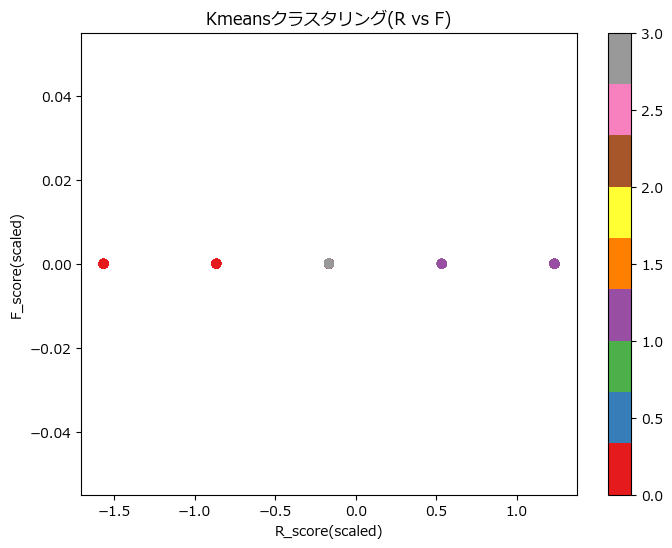

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#RFMスコアの標準化（スケーリング）
X=rfm[['R_score','F_score','M_score']]
      
scaler=StandardScaler()

X_scaled=scaler.fit_transform(X)

#Kmeansでクラスタリング
kmeans=KMeans(n_clusters=4,random_state=42)

rfm['Cluster']=kmeans.fit_predict(X_scaled)

#Kmeansでクラスタリング
kmeans=KMeans(n_clusters=4,random_state=42)

rfm['Cluster']=kmeans.fit_predict(X_scaled)

#クラスタごとの特徴を確認
rfm.groupby('Cluster').agg({
    'R_score':'mean',
    'F_score':'mean',
    'M_score':'mean',
    'customer_id':'count'
}).rename(columns={'customer_id':'Count'})

#クラスタの可視化（2軸）
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Meiryo'

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0],
            X_scaled[:,1],
            c=rfm['Cluster'],
            cmap='Set1')
plt.xlabel('R_score(scaled)')
plt.ylabel('F_score(scaled)')
plt.title('Kmeansクラスタリング(R vs F)')
plt.colorbar()
plt.show()

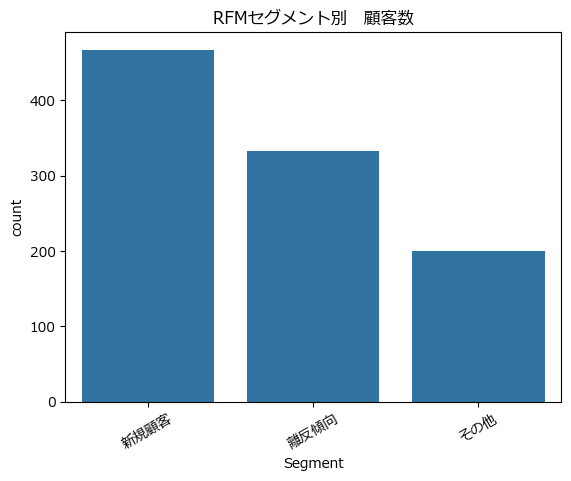

In [48]:
#ルールで顧客タイプを分類
def segment(row): 
    if row['R_score']>=4 and row['F_score']>=4 and row['M_score']>=4: return '優良顧客'
    elif row['R_score']<=2 and row['F_score']<=2: return '離反傾向'
    elif row['R_score']>=4 and row['F_score']<=2: return '新規顧客'
    elif row['R_score']<=2 and row['F_score']>=4: return '要再活性化'
    else: return 'その他'

rfm['Segment']=rfm.apply(segment,axis=1)

#人数確認＆可視化
rfm['Segment'].value_counts()

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=rfm,x='Segment',order=rfm['Segment'].value_counts().index)
plt.xticks(rotation=30)
plt.title('RFMセグメント別　顧客数')
plt.show()

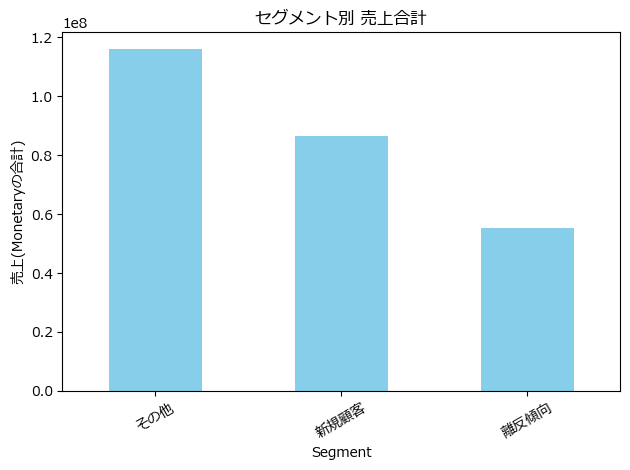

In [52]:
#セグメントごとの売上をみたい
segment_sales=rfm.groupby('Segment')['Monetary'].agg(['count','mean','sum']).sort_values('sum',ascending=False)

#売上合計を棒グラフにする
import matplotlib.pyplot as plt

segment_sales['sum'].plot(kind='bar',color='skyblue')
plt.title('セグメント別 売上合計')
plt.ylabel('売上(Monetaryの合計)')
plt.xlabel('Segment')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [53]:
rfm.to_csv('rfm_result.csv',index=False)

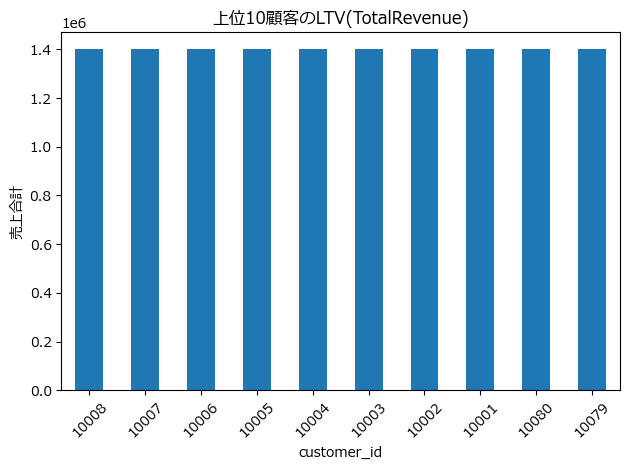

In [55]:
#顧客ごとのLTV指標を集計
ltv_df=rfm.groupby('customer_id').agg({
    'Monetary':'sum',
    'Frequency':'sum'
}).rename(columns={
    'Monetary':'TotalRevenue',
    'Frequency':'TotalOrders'
})

#平均注文単価を追加
ltv_df['AverageOrderValue']=ltv_df['TotalRevenue']/ltv_df['TotalOrders']

#LTVが高い順にソートして表示
ltv_df=ltv_df.sort_values('TotalRevenue',ascending=False)
ltv_df.head()

ltv_df['TotalRevenue'].head(10).plot(kind='bar')
plt.title('上位10顧客のLTV(TotalRevenue)')
plt.ylabel('売上合計')
plt.xlabel('customer_id')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
#離反フラグの定義
rfm['churned']=rfm['Recency'].apply(lambda x: 1 if x > 180 else 0)

#特徴量を用意
features=rfm[['R_score','F_score','M_score']]
target=rfm['churned']

#モデル構築
from sklea
rn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.3,random_state=42)

model=RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       147

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



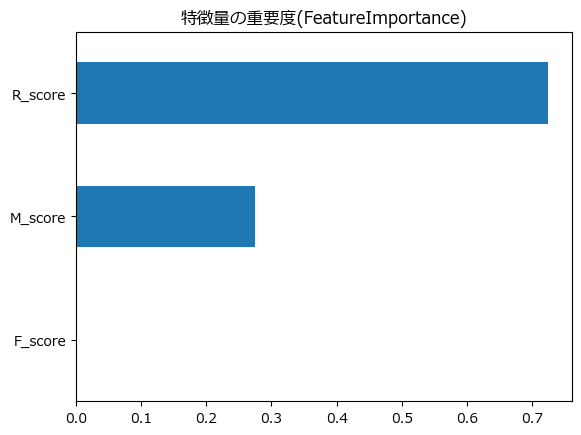

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

#特徴量の重要度を取得
importance=pd.Series(model.feature_importances_,index=features.columns)
importance.sort_values().plot(kind='barh')
plt.title('特徴量の重要度(FeatureImportance)')
plt.show()

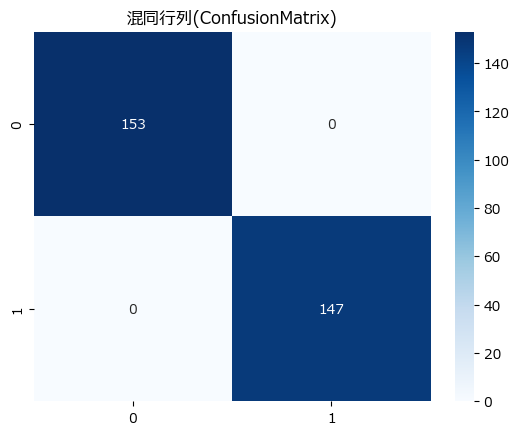

In [60]:
#偏向行列を確認
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel=('Predicted')
plt.ylabel=('actual')
plt.title('混同行列(ConfusionMatrix)')
plt.show()

In [62]:
#特徴量をRスコア除外バージョンに変更
features_no_r=rfm[['F_score','M_score']]
target=rfm['churned']

#データを分割＆モデル再学習
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train,X_test,y_train,y_test=train_test_split(features_no_r,target,test_size=0.3,random_state=42)

model2=RandomForestClassifier(random_state=42)
model2.fit(X_train,y_train)
y_pred=model2.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       153
           1       0.83      0.72      0.77       147

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300

